# (Distil)BERT classifier for propositions

This DistilBERT implementation follows [Raschka et al. (2022)](https://github.com/rasbt/machine-learning-book)
from pp. 575-586. Here is the corresponding: [code](https://github.com/rasbt/machine-learning-book/blob/main/ch16/ch16-part3-bert.ipynb).

Sebastian Raschka,  Yuxi Liu and Vahid Mirjalili.  2022. Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python. Packt Publishing.

## Settings and imports

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

import os
import sys
PATH = r"/content/gdrive/My Drive/Colab Notebooks/AM_BERT_classification"
os.chdir(PATH)

# Create directory, if it does not exist
os.makedirs("models", exist_ok=True)

# Add the subdirectory to the sys.path
subdirectory_path = os.path.join(os.getcwd(), "scripts")
sys.path.insert(0, subdirectory_path)

Mounted at /content/gdrive


In [ ]:
from corpus_loader import CorpusLoader
from cdcp_preprocessor import CDCPPropositionPrepper

import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR

from transformers import BertForSequenceClassification
from transformers import BertTokenizerFast

from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast

Specifying general settings to make the results reproducible.

In [ ]:
torch.backends.cudnn.deterministic = True
random_seed = 80
torch.manual_seed(random_seed)

available_gpu = torch.cuda.is_available()

if available_gpu:
  print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
  print("GPU not available.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is available: NVIDIA L4


## Data

Loading propositions from the [Cornell eRulemaking Corpus – CDCP](https://facultystaff.richmond.edu/~jpark/papers/jpark_lrec18.pdf) with custom classes (CorpusLoader, CDCPPropositionPrepper). The arguments are labeled with five categories: `fact`, `policy`, `reference`, `testimony`, `value`.

**Terminology**

EDU = elementary discourse unit \
ADU = argumentation discourse unit

In the CDCP corpus, there is no distinction made between EDU and ADU.

**Reference**

Joonsuk Park and Claire Cardie. 2018. A Corpus of eRulemaking User Comments
for Measuring Evaluability of Arguments. In Proceedings of the Eleventh
International Conference on Language Resources and Evaluation (LREC 2018),
Miyazaki, Japan. European Language Resources Association (ELRA).

The **corpus statistics** as of 11.07.2024 is as follows:

### Corpus Information
| Metric                    | Value                |
|---------------------------|----------------------|
| All documents from corpus | 731                  |
| Training split            | 581 (79.48%)         |
| Test split                | 150 (20.52%)         |
| Average EDUs per document | 6.746922024623803    |

### Categories
| Type       | Training Count | Test Count | Total Count |
|------------|----------------|------------|-------------|
| Fact       | 654            | 132        | 786         |
| Policy     | 662            | 153        | 815         |
| Reference  | 31             | 1          | 32          |
| Testimony  | 873            | 244        | 1117        |
| Value      | 1686           | 496        | 2182        |

Please note that the number of facts slightly differs from the original publication. A total of 786 facts were counted with the script in `scripts/cdcp_preprocessor.py`, whereas the original publication reported 785 [(Park & Cardie 2018, p. 1627)](https://facultystaff.richmond.edu/~jpark/papers/jpark_lrec18.pdf).

In [ ]:
# The URL for the CDPC as zip file
url_cdcp = "https://facultystaff.richmond.edu/~jpark/data/cdcp_acl17.zip"
cdcp_save_path = "data/corpus_1/"
cdcp_path_train = "data/corpus_1/cdcp/train/"
cdcp_path_test = "data/corpus_1/cdcp/test/"
cdcp_file_type_ann = ".ann.json"
cdcp_file_type_text = ".txt"

corpus_loader = CorpusLoader()
propositions = CDCPPropositionPrepper()

# If data/corpus_1/ exists, download will be skipped.
corpus_loader.download_file_from(url_cdcp, cdcp_save_path)

#### Training set ####

training_annotation = corpus_loader.load_files_from(cdcp_path_train,
                                                    cdcp_file_type_ann)
training_text = corpus_loader.load_files_from(cdcp_path_train,
                                              cdcp_file_type_text)

training_set = propositions.instance_extraction(training_annotation,
                                                  training_text)
print(training_set.head())
print(training_set.shape)

#### Test set ####

test_annotation = corpus_loader.load_files_from(cdcp_path_test,
                                                cdcp_file_type_ann)
test_text = corpus_loader.load_files_from(cdcp_path_test,
                                          cdcp_file_type_text)

test_set = propositions.instance_extraction(test_annotation, test_text)
print(test_set.head())
print(test_set.shape)

Path data/corpus_1/ already exists. Skipping download.
    label                                               text
0   value  State and local court rules sometimes make def...
1   value   For example, when a person who allegedly owes...
2  policy   I urge the CFPB to find practices that involv...
3    fact  There is currently a split between the Ninth a...
4    fact   In many states, the nominal defendant is the ...
(3906, 2)
    label                                               text
0    fact  Recently, courts have held that debt collector...
1   value   As the NAF studies reflect, arbitration has n...
2  policy   I urge the CFPB to include in a rule language...
3   value  When alleged debtors are served with state cou...
4  policy   Any requirements to file papers to avoid defa...
(1026, 2)


Applying numeric labels to training and test set. We are dealing with a multi-class classification task.

In [ ]:
label_mapping = {
    "fact": 0,
    "policy": 1,
    "reference": 2,
    "testimony": 3,
    "value": 4
}

training_set["label"] = training_set["label"].map(label_mapping)
test_set["label"] = test_set["label"].map(label_mapping)
print(training_set.head())

   label                                               text
0      4  State and local court rules sometimes make def...
1      4   For example, when a person who allegedly owes...
2      1   I urge the CFPB to find practices that involv...
3      0  There is currently a split between the Ninth a...
4      0   In many states, the nominal defendant is the ...


Splitting the training set into training and validation sets and stratifying the labels. Stratification only works with shuffling. The CDCP corpus comes with a training and test split where 80% of all instances belong to the training set and 20% to the test set. To create a validation set, which corresponds to 10% of the overall data we can further split the training set by 12,5% (taken from the 80% training split, this results in 10% of the overall data). In this fashion, we get a 70:10:20 split.

In [ ]:
X = training_set["text"]
y = training_set["label"]
X_test = test_set["text"]
y_test = test_set["label"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.125,
                                                      random_state=random_seed,
                                                      stratify=y)

X_train = X_train.values  # PyTorch tokenizer can handle lists or strings
X_valid = X_valid.values
X_test = X_test.values
y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(X_train[0])
print(y_train[0])

(3417,)
(489,)
(1026,)
There's no need to be rude about it.
4


## Data preparation

Tokenizing the dataset with the tokenizer taken from the pre-trained model. The advantage of using the inherited tokenizer is that "the consistency
between the pre-trained model and the dataset" is maintained
(Raschka 2022, p. 577)

The tokenizer can create a schema that resembles the following structure:

> [CLS] Proposition 1 [SEP][PAD] [PAD] ...

Where [CLS] and [SEP] are special tokens used for telling the BERT model where propositions start and end. [PAD] is used for padding so that each sample is of equal size.

In [ ]:
"""tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
    )
"""

tokenizer = BertTokenizerFast.from_pretrained(
    "bert-base-uncased"
    )

train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
valid_encodings = tokenizer(list(X_valid), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Let's visualize the tokenized instances with corresponding ids and masks.

In [ ]:
for i in range(3):
    print(f"input_ids: {train_encodings['input_ids'][i]}")
    print(f"attention_mask: {train_encodings['attention_mask'][i]}")
    print(f"sentence: {tokenizer.decode(train_encodings['input_ids'][i])}")

input_ids: [101, 2045, 1005, 1055, 2053, 2342, 2000, 2022, 12726, 2055, 2009, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sentence: [CLS] there's no need to be rude about it. [SEP] [PAD] [PAD

A self-defined data class helps with customizing all related features and functions.

In [ ]:
class CDCPDataset(torch.utils.data.Dataset):
    """
    Self-defined data class to customize features by changing some magic
    methods. __getitem__ only extraxts the most relevant information from the
    encodings.

    Cf. Raschka et al. (2022, p. 577-8)
    """

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx])
                for key, val in self.encodings.items()}
        item["label"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Creating PyTorch Dataloaders:

The data was already shuffled with the splits to stratisfy and the classes.

Shuffling the data stabilizes the training process and can potentially enhance the model's final performance. Principally, it only needs to be applied to the training set. The metrics calculated for the validation and test sets will remain the same regardless of the data order.

In [ ]:
train_dataset = CDCPDataset(train_encodings, y_train)
valid_dataset = CDCPDataset(valid_encodings, y_valid)
test_dataset = CDCPDataset(test_encodings, y_test)

batch_size = 128  # Slight boost for T4 GPU if batch size is 128

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=False
)


## Fine-tuning the model

### [BERT](https://huggingface.co/google-bert/bert-base-uncased)
BERT is a transformer model that has been pretrained on a vast collection of English texts using a self-supervised approach. The ***BertForSequenceClassification*** version is designed for sequence classification. It includes a classification head on top of the pooled output, specifically for tasks like sentiment analysis, spam detection, etc. When we instantiate BertForSequenceClassification, the loss function used is `CrossEntropyLoss`. Passing the labels along with the input to the model is sufficient, the Hugging Face library automatically computes the loss if the labels are provided.

### [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased):

The DistilBERT base uncased model can also be used as it is faster, lighter, and smaller than BERT [(Sanh et al. 2019)](https://arxiv.org/abs/1910.01108), but reaches performance results close to BERT.

In [ ]:
"""
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=5  # Fact, policy, reference, testimony, value
)
"""
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=5  # Fact, policy, reference, testimony, value
)
model_name = f"models/Bert_proposition_cdcp_class1_3.pt"
model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = LinearLR(optimizer,
                     start_factor=1.0,
                     end_factor=0.3,
                     total_iters=10)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy function to evaluate the model:

In [ ]:
def compute_accuracy(model, data_loader, device):
    """
    Cf. Raschka et al. (2022, p. 579)
    """
    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            predicted_labels = torch.argmax(logits, dim=1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()

        return correct_pred.float()/num_examples * 100

F1 function to evaluate the model:

In [ ]:
def compute_f1_scores(model, data_loader, device):
    with torch.no_grad():

        all_labels = []
        all_predictions = []

        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            predicted_labels = torch.argmax(logits, dim=1)

            # If the tensors are on the GPU, .cpu() moves them to the CPU.
            # This step is necessary because the numpy() method is not supported
            # on GPU tensors.
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

        # Create a report dictionary
        report = classification_report(all_labels,
                                       all_predictions,
                                       target_names=["fact",
                                                     "policy",
                                                     "reference",
                                                     "testimony",
                                                     "value"],
                                       output_dict=True)


        return report

Function to evaluate loss:

In [ ]:
def compute_loss(model, data_loader, device):
    # Dropout is disabled and batch normalization uses the learned statistics
    # instead of the statistics of the current batch.
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss, logits = outputs["loss"], outputs["logits"]

            running_loss += loss.item()

    final_loss = running_loss/ len(data_loader)

    return final_loss


### Training:

This is the training loop for finetuning the model. After some manual tests with DistilBERT, five epochs are sufficient for the model to converge for the given task.

In [ ]:
start_time = time.time()
num_epochs = 5

train_acc_history = [0] * num_epochs
valid_acc_history = [0] * num_epochs

train_loss_history = [0] * num_epochs
valid_loss_history = [0] * num_epochs

# Cf. Raschka et al. (2022, p. 580-1)
for epoch in range(num_epochs):

    model.train()
    running_train_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):

        # Prepare data
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss, logits = outputs["loss"], outputs["logits"]

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Scheduler step
        scheduler.step()

        # Logging
        if not batch_idx % 10:
            print(f"Epoch: {epoch+1:04d}/{num_epochs:04d}"
                  f" | Batch "
                  f"{batch_idx:04d}/"
                  f"{len(train_loader):04d} | "
                  f"Loss: {loss:.4f}")

    train_loss = running_train_loss / len(train_loader)
    valid_loss = compute_loss(model, valid_loader, device)

    train_loss_history[epoch] = train_loss
    valid_loss_history[epoch] = valid_loss

    print(f"Epoch: {epoch+1}/{num_epochs} | "
          f"Training Loss: {train_loss:.4f} | "
          f"Validation Loss: {valid_loss:.4f}")

    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device)
        valid_acc = compute_accuracy(model, valid_loader, device)
        print(f"Training accuracy: "
              f"{train_acc:.2f}%"
              f"\nValidation accuracy: "
              f"{valid_acc:.2f}%"
              )

    train_acc_history[epoch] = train_acc
    valid_acc_history[epoch] = valid_acc

# Evaluate and save model
model.eval()
torch.save(model.state_dict(), model_name)

print(f"Time elapsed: {(time.time() - start_time)/60:.2f} min")

Epoch: 0001/0005 | Batch 0000/0027 | Loss: 1.6239
Epoch: 0001/0005 | Batch 0010/0027 | Loss: 1.2632
Epoch: 0001/0005 | Batch 0020/0027 | Loss: 1.0905
Epoch: 1/5 | Training Loss: 1.2055 | Validation Loss: 0.8910
Training accuracy: 72.70%
Validation accuracy: 72.19%
Epoch: 0002/0005 | Batch 0000/0027 | Loss: 0.8630
Epoch: 0002/0005 | Batch 0010/0027 | Loss: 0.7753
Epoch: 0002/0005 | Batch 0020/0027 | Loss: 0.5791
Epoch: 2/5 | Training Loss: 0.7564 | Validation Loss: 0.6138
Training accuracy: 83.35%
Validation accuracy: 80.98%
Epoch: 0003/0005 | Batch 0000/0027 | Loss: 0.5994
Epoch: 0003/0005 | Batch 0010/0027 | Loss: 0.5625
Epoch: 0003/0005 | Batch 0020/0027 | Loss: 0.4465
Epoch: 3/5 | Training Loss: 0.5097 | Validation Loss: 0.5249
Training accuracy: 89.14%
Validation accuracy: 80.98%
Epoch: 0004/0005 | Batch 0000/0027 | Loss: 0.4427
Epoch: 0004/0005 | Batch 0010/0027 | Loss: 0.4382
Epoch: 0004/0005 | Batch 0020/0027 | Loss: 0.3111
Epoch: 4/5 | Training Loss: 0.3591 | Validation Loss: 0

## Evaluation

Visualizing accuracy during training with Matplotlib.

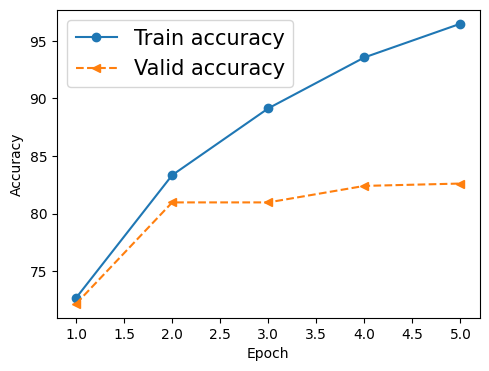

In [ ]:
x_arr = np.arange(len(train_acc_history)) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, [e.cpu() for e in train_acc_history],
        "-o",
        label="Train accuracy")
ax.plot(x_arr, [e.cpu() for e in valid_acc_history],
        "--<",
        label="Valid accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(fontsize=15)

Visualizing loss during training with Matplotlib.


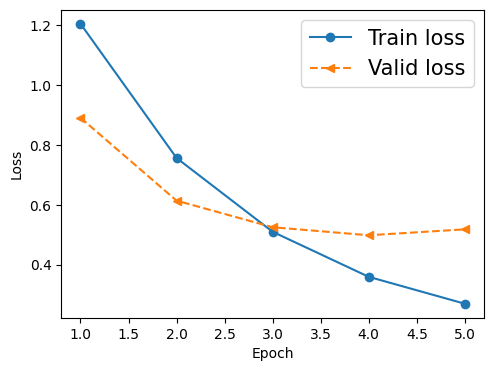

In [ ]:
x_arr = np.arange(len(train_loss_history)) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, train_loss_history, "-o", label="Train loss")
ax.plot(x_arr, valid_loss_history, "--<", label="Valid loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(fontsize=15)

# Metrics:

To report a full range of metrics, we can use the customized `compute_f1_scores`. The function returns `precision`, `recall`, `accuracy`, `macro F1` and `weighted F1` scores. For an imbalanced distribution of classes, it is reasonable to consider the weighted F1 score because it takes the support count for each class into account.

Macro F1 := Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

Micro F1 / weighted average := Calculate metrics globally by counting the total true positives false negatives and false positives.

In [ ]:
if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_name))
else:
    model.load_state_dict(torch.load(model_name,
                                     map_location=torch.device("cpu")))

report = compute_f1_scores(model, test_loader, device)
print(f"Test score: {report}")

Individual F1 score: {'fact': {'precision': 0.5986394557823129, 'recall': 0.6666666666666666, 'f1-score': 0.6308243727598566, 'support': 132}, 'policy': {'precision': 0.8253012048192772, 'recall': 0.8954248366013072, 'f1-score': 0.858934169278997, 'support': 153}, 'reference': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, 'testimony': {'precision': 0.8455284552845529, 'recall': 0.8524590163934426, 'f1-score': 0.8489795918367347, 'support': 244}, 'value': {'precision': 0.8583690987124464, 'recall': 0.8064516129032258, 'f1-score': 0.8316008316008315, 'support': 496}, 'accuracy': 0.8128654970760234, 'macro avg': {'precision': 0.8255676429197181, 'recall': 0.8442004265129285, 'f1-score': 0.834067793095284, 'support': 1026}, 'weighted avg': {'precision': 0.8171067334809152, 'recall': 0.8128654970760234, 'f1-score': 0.8141430584660462, 'support': 1026}}


Finally, we can log the results at `results/log.json`.

In [ ]:
file_path = "results/log.json"

try:
    with open(file_path, "r") as file:
        data = json.load(file)
except FileNotFoundError:
    data = {}
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

data[model_name] = report

with open(file_path, "w") as file:
    json.dump(data, file, indent=4)

print(f"Updated data written to {file_path}.")